## **Studi Kasus Rekomendasi Film Berdasarkan Genre dan Data Pemeran Film (Actor) dengan Model Spearman Rank Correlation dan Algoritma Item-Based Collaborative Filtering**

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Mounting G-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load Dataset
df=pd.read_csv('drive/MyDrive/SR/IMDB Top 250 Movies.csv')
df.head()

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000,28884504,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont"
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000,250341816,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola"
2,3,The Dark Knight,2008,9.0,"Action,Crime,Drama",PG-13,2h 32m,Why So Serious?,185000000,1006234167,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich...",Christopher Nolan,"Jonathan Nolan,Christopher Nolan,David S. Goyer"
3,4,The Godfather Part II,1974,9.0,"Crime,Drama",R,3h 22m,All the power on earth can't change destiny.,13000000,47961919,"Al Pacino,Robert De Niro,Robert Duvall,Diane K...",Francis Ford Coppola,"Francis Ford Coppola,Mario Puzo"
4,5,12 Angry Men,1957,9.0,"Crime,Drama",Approved,1h 36m,Life Is In Their Hands -- Death Is On Their Mi...,350000,955,"Henry Fonda,Lee J. Cobb,Martin Balsam,John Fie...",Sidney Lumet,Reginald Rose


**Data Preprocessing**

In [ ]:
# Pengecekan apakah dataset memiliki nilai null
df.isnull().sum()

rank           0
name           0
year           0
rating         0
genre          0
certificate    0
run_time       0
tagline        0
budget         0
box_office     0
casts          0
directors      0
writers        0
dtype: int64

In [ ]:
# Pengecekan apakah terdapat data duplikat
df.duplicated().sum()

0

In [ ]:
# Pengecekan apakah ada duplikat kolom
have_duplicate_rows = df.duplicated().any()
have_duplicate_rows

False

In [ ]:
# Info Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         250 non-null    int64  
 1   name         250 non-null    object 
 2   year         250 non-null    int64  
 3   rating       250 non-null    float64
 4   genre        250 non-null    object 
 5   certificate  250 non-null    object 
 6   run_time     250 non-null    object 
 7   tagline      250 non-null    object 
 8   budget       250 non-null    object 
 9   box_office   250 non-null    object 
 10  casts        250 non-null    object 
 11  directors    250 non-null    object 
 12  writers      250 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 25.5+ KB


In [ ]:
#visualisasi dataset top 10 film berdasarkan genre
top_rates = df.nlargest(10, 'rating')
fig = go.Figure(data=[go.Bar(x=top_rates['genre'], y=top_rates['rating'])])
fig.update_layout(title='Top 10 Movies by Genre', )
fig.show()

In [ ]:
# Membuat duplicate dataset
df_Film = df

In [ ]:
# Menambahkan kolom user_id
# df_Film['user_id'] = np.tile(np.arange(1, 3), 125)[:len(df_Film)]
df_Film["user_id"] = np.arange(len(df))

In [ ]:
# Menghilangkan kolom yang tidak diperlukan
df_Film = df_Film.drop(["certificate", "run_time", "tagline", "budget", "box_office", "writers"], axis=1)

In [ ]:
# Menggabungkan kolom casts, dan directors
df_Film["Sutradara_Pemeran"] = df_Film["casts"] + df_Film["directors"]
df_Film["Sutradara_Pemeran"] = df_Film["Sutradara_Pemeran"].apply(lambda x: ' '.join([w.strip(",.;:!?()'\"") for w in x]))
df_Film = df_Film.drop(["casts", "directors"], axis=1)

In [ ]:
# Membuat Info Film yang berisikan data genre, casts, dan directors
df_Film["Film_Info"] = df_Film["genre"] + " " + df_Film["Sutradara_Pemeran"]

In [ ]:
#Data Info Setelah Preprocessing
df_Film.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               250 non-null    int64  
 1   name               250 non-null    object 
 2   year               250 non-null    int64  
 3   rating             250 non-null    float64
 4   genre              250 non-null    object 
 5   user_id            250 non-null    int64  
 6   Sutradara_Pemeran  250 non-null    object 
 7   Film_Info          250 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 15.8+ KB


In [ ]:
#Data Set Setelah Preprocessing
df_Film.head()

,rank,name,year,rating,genre,user_id,Sutradara_Pemeran,Film_Info
0,1,The Shawshank Redemption,1994,9.3,Drama,0,T i m R o b b i n s M o r g a n F r e e m...,Drama T i m R o b b i n s M o r g a n F r...
1,2,The Godfather,1972,9.2,"Crime,Drama",1,M a r l o n B r a n d o A l P a c i n o ...,"Crime,Drama M a r l o n B r a n d o A l P..."
2,3,The Dark Knight,2008,9.0,"Action,Crime,Drama",2,C h r i s t i a n B a l e H e a t h L e d...,"Action,Crime,Drama C h r i s t i a n B a l e..."
3,4,The Godfather Part II,1974,9.0,"Crime,Drama",3,A l P a c i n o R o b e r t D e N i r o...,"Crime,Drama A l P a c i n o R o b e r t D..."
4,5,12 Angry Men,1957,9.0,"Crime,Drama",4,H e n r y F o n d a L e e J C o b b M...,"Crime,Drama H e n r y F o n d a L e e J ..."


**Algoritma Rekomendasi**

In [ ]:
# Generate TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_Film["Film_Info"])

In [ ]:
# Menghitung matriks kesamaan dengan Spearman Rank Correlation
spearman_similarity_matrix, _ = spearmanr(X.toarray(), axis=1)

# Train-test split
train_df, test_df = train_test_split(df_Film, test_size=0.2, random_state=42)

In [ ]:
# Fungsi rekomendasi berdasarkan text_similarities dari genre film yang ditonton oleh user
def recommend_movie(user_id, movie_title):
    num_recommendations=10
    # Mendapatkan genre film yang ditonton oleh user
    user_watched_movie = df[(df['user_id'] == user_id) & (df['name'] == movie_title)]

    if user_watched_movie.empty:
        print(f"Error: User {user_id} tidak menonton film {movie_title}")
        return None

    user_watched_index = user_watched_movie.index[0]

     # Menghitung text_similarities antara teks film yang ditonton dengan setiap film
    text_similarities = spearman_similarity_matrix[user_watched_index]

    # Mengurutkan film berdasarkan text_similarities
    movie_indices = text_similarities.argsort()[::-1]

    # Mengambil film-film dengan text_similarities tertinggi (kecuali film yang sudah ditonton oleh user)
    recommended_movies = df.iloc[movie_indices[~df.iloc[movie_indices].index.isin(user_watched_movie.index)][:num_recommendations]]

    return recommended_movies

In [ ]:
movie_title = 'The Dark Knight'
idUser = 2
recommendations = recommend_movie(idUser, movie_title)

if recommendations is not None:
  # Mengubah DataFrame menjadi array
    recommended_movies_array = recommendations["name"].values
  #visualisasi hasil yang direkomendasikan
    recommended_movies_df = pd.DataFrame({'Recommended Movies': recommended_movies_array})
    fig = go.Figure(data=[go.Table(
      header=dict(values=['Rekomendasi Film']),
      cells=dict(values=[recommended_movies_df['Recommended Movies']])
    )])

    fig.update_layout(title_text=f"Film-film yang direkomendasikan untuk User {idUser} setelah menonton film {movie_title}'")
    fig.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**Pengujian Akurasi**

Mean Absolute Error (MAE): 0.6388106330284998



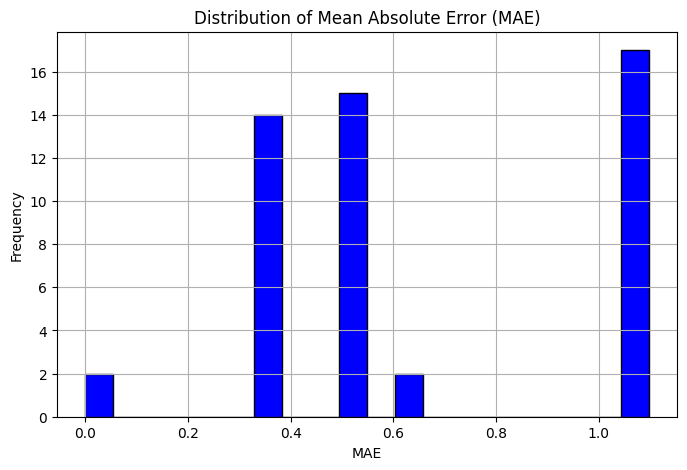

In [ ]:
mae_scores = []

for index, row in test_df.iterrows():
    user_id = row['user_id']
    movie_name = row['name']

    # Ambil indeks film dan pengguna dari DataFrame
    movie_index = df[df['name'] == movie_name].index[0]
    user_index = df[df['user_id'] == user_id].index[0]

    # Pastikan X adalah array NumPy atau sparse matrix
    X_array = X.toarray() if hasattr(X, 'toarray') else X

    # Pastikan dimensi yang benar dan konversi jika perlu
    movie_vector = X_array[movie_index].reshape(1, -1)
    user_vector = X_array[user_index].reshape(1, -1)

    # Menyelaraskan indeks sebelum perbandingan
    movie_df = pd.DataFrame(movie_vector, index=[0])
    user_df = pd.DataFrame(user_vector, index=[0])
    movie_df, user_df = movie_df.align(user_df, axis=1, copy=False)

    # Hitung kesamaan aktual dan prediksi dengan Spearman Rank Correlation
    actual_similarity, _ = spearmanr(movie_df.values.flatten(), user_df.values.flatten())

    # Prediksi kesamaan menggunakan recommend_movie
    recommended_movie_name = recommend_movie(user_id, movie_name)
    recommended_movie_index = df[df['name'] == recommended_movie_name].index[0]
    recommended_movie_vector = X_array[recommended_movie_index].reshape(1, -1)

    # Menyelaraskan indeks pada DataFrame hasil recommend_movie
    recommended_movie_df = pd.DataFrame(recommended_movie_vector, index=[0])
    recommended_movie_df, user_df = recommended_movie_df.align(user_df, axis=1, copy=False)

    # Hitung kesamaan prediksi dengan Spearman Rank Correlation
    predicted_similarity, _ = spearmanr(recommended_movie_df.values.flatten(), user_df.values.flatten())

    # Hitung perbedaan absolut dan tambahkan ke mae_scores
    mae_scores.append(abs(predicted_similarity - actual_similarity))

# Hitung MAE
mae = sum(mae_scores) / len(mae_scores)
print(f'Mean Absolute Error (MAE): {mae}')
print('')
# Visualisasi histogram MAE
plt.figure(figsize=(8, 5))
plt.hist(mae_scores, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Mean Absolute Error (MAE)')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()